In [ ]:
# ------------------------------------------------
# Cell 1: Import Libraries
# ------------------------------------------------
import os
import json
import re
import string
from collections import Counter

# Hugging Face Datasets
from datasets import load_dataset

# NLTK
import nltk
nltk.download('punkt')
nltk.download('wordnet')

# For DataFrame & Parquet
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# SentenceTransformers
from sentence_transformers import SentenceTransformer

# Parallelization
from joblib import Parallel, delayed

In [2]:
# ------------------------------------------------
# Cell 2: Load & Filter Dataset (English only)
# ------------------------------------------------
NUM_PROC = 8  # Adjust based on your machine

ds = load_dataset("allenai/WildChat-1M", split="train")

# Filter rows to only include those where overall 'language' field is "English"
ds_en = ds.filter(lambda x: x["language"] == "English", num_proc=NUM_PROC)
print("After filtering, dataset size:", ds_en.num_rows)


After filtering, dataset size: 478498


In [3]:
# ------------------------------------------------
# Cell 3: Helper Functions
# ------------------------------------------------

def process_row(row):
    
    """
    Process a single dataset row to add:
      - first_user_query
      - device_type
    """

    def get_first_user_query(conversation):
        """
        From a list of conversation turns, return the content of
        the first turn where the role is 'user'.
        """
        if not conversation:
            return ""
        for turn in conversation:
            role = turn.get("role")
            if isinstance(role, str) and role.lower() == "user":
                return turn.get("content", "")
        return ""

    def get_device_type(header):
        """
        Categorize device type into one of: [mobile, windows, mac, other, unknown].
        - None or missing user-agent => "unknown"
        - user-agent includes any of ["mobile", "android", "iphone"] => "mobile"
        - "windows" => "windows"
        - "macintosh" => "mac"
        - everything else => "other"
        """
        if not header:
            return "unknown"
        ua = header.get("user-agent", None)
        if not ua or not isinstance(ua, str):
            return "unknown"
        
        ua_lower = ua.lower()
        if any(token in ua_lower for token in ["mobile", "android", "iphone"]):
            return "mobile"
        elif "windows" in ua_lower:
            return "windows"
        elif "macintosh" in ua_lower:
            return "mac"
        else:
            return "other"
        
    row["first_user_query"] = get_first_user_query(row["conversation"])
    row["device_type"] = get_device_type(row.get("header"))
    return row



In [4]:
# ------------------------------------------------
# Cell 4: Map the dataset to add new columns
# ------------------------------------------------
ds_en = ds_en.map(process_row, num_proc=NUM_PROC)


In [5]:
# ------------------------------------------------
# Cell 5: Process dataset in chunks to generate embeddings
# ------------------------------------------------
import os
import json
import numpy as np  # for type-checking the embeddings

# Define the embedding model (it is assumed that the previous cells have already defined ds_en and processed rows)
model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

# Output file for embeddings (JSON Lines format)
EMBEDDINGS_OUTFILE = "wildchat_embeddings.jsonl"
if os.path.exists(EMBEDDINGS_OUTFILE):
    os.remove(EMBEDDINGS_OUTFILE)

# Set the chunk size and (internal) batch size
CHUNK_SIZE = 5000   # Adjust based on memory and runtime considerations
BATCH_SIZE = 64     # Pass batch_size to model.encode for internal parallelization

total_records = ds_en.num_rows
num_chunks = (total_records // CHUNK_SIZE) + (1 if total_records % CHUNK_SIZE != 0 else 0)
print("Number of chunks:", num_chunks)

for chunk_idx in range(num_chunks):
    start_idx = chunk_idx * CHUNK_SIZE
    end_idx = min((chunk_idx + 1) * CHUNK_SIZE, total_records)
    
    # Select chunk rows from the dataset
    ds_chunk = ds_en.select(range(start_idx, end_idx))
    chunk_list = list(ds_chunk)  # Convert chunk to a list for processing

    # Prepare the list of texts to encode.
    # If a row does not have 'first_user_query', return an empty string.
    texts = [row.get("first_user_query", "") for row in chunk_list]

    try:
        # Try to encode the entire chunk at once
        embeddings = model.encode(texts, batch_size=BATCH_SIZE, show_progress_bar=False, convert_to_numpy=True)
    except Exception as e:
        print(f"Batch encoding failed on chunk {chunk_idx+1} with error: {e}. Falling back to row-by-row encoding.")
        embeddings = []
        for text in texts:
            try:
                emb = model.encode(text, convert_to_numpy=True) if text else []
            except Exception as e2:
                emb = []  # On failure, assign an empty embedding
            embeddings.append(emb)

    # Build the result for each row in the chunk
    results = []
    for i, emb in enumerate(embeddings):
        # Ensure the embedding is converted to a list (JSON serializable)
        emb_as_list = emb.tolist() if isinstance(emb, np.ndarray) else emb
        results.append({
            "id": start_idx + i,
            "conversation_hash": chunk_list[i]["conversation_hash"],
            "embedding": emb_as_list
        })
    
    # Write current chunk results to the JSONL file (append mode)
    with open(EMBEDDINGS_OUTFILE, "a", encoding="utf-8") as outf:
        for res in results:
            outf.write(json.dumps(res) + "\n")

    print(f"Chunk {chunk_idx+1}/{num_chunks} processed and written.")

print("All embeddings written to", EMBEDDINGS_OUTFILE)

Number of chunks: 96
Chunk 1/96 processed and written.
Chunk 2/96 processed and written.
Chunk 3/96 processed and written.
Chunk 4/96 processed and written.
Chunk 5/96 processed and written.
Chunk 6/96 processed and written.
Chunk 7/96 processed and written.
Chunk 8/96 processed and written.
Chunk 9/96 processed and written.
Chunk 10/96 processed and written.
Chunk 11/96 processed and written.
Chunk 12/96 processed and written.
Chunk 13/96 processed and written.
Chunk 14/96 processed and written.
Chunk 15/96 processed and written.
Chunk 16/96 processed and written.
Chunk 17/96 processed and written.
Chunk 18/96 processed and written.
Chunk 19/96 processed and written.
Chunk 20/96 processed and written.
Chunk 21/96 processed and written.
Chunk 22/96 processed and written.
Chunk 23/96 processed and written.
Chunk 24/96 processed and written.
Chunk 25/96 processed and written.
Chunk 26/96 processed and written.
Chunk 27/96 processed and written.
Chunk 28/96 processed and written.
Chunk 29

In [6]:
# ------------------------------------------------
# Cell 6: Save essential info to Parquet
# ------------------------------------------------
# Convert final ds_en to Pandas
df = ds_en.to_pandas()

# Keep only essential columns
cols_to_keep = [
    "conversation_hash",
    "hashed_ip",
    "timestamp",
    "conversation",
    "first_user_query",
    "device_type",
]
df_subset = df[cols_to_keep]

# Convert to Arrow Table & save as Parquet
table = pa.Table.from_pandas(df_subset)
pq.write_table(table, "wildchat_subset.parquet")

print("Saved essential subset to wildchat_subset.parquet")

Saved essential subset to wildchat_subset.parquet


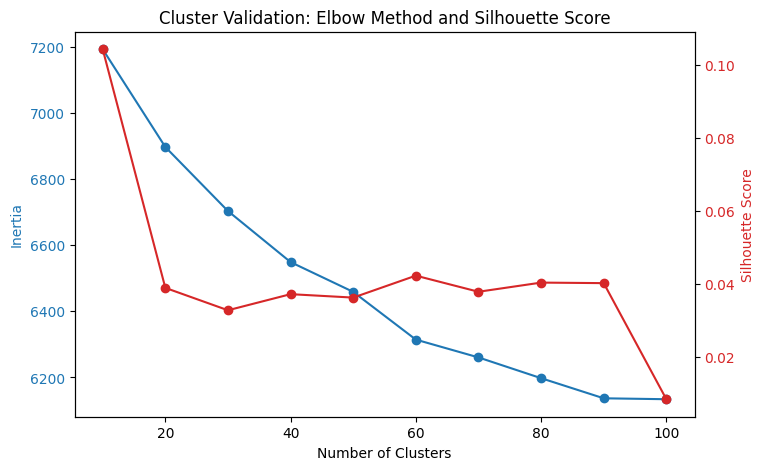

In [35]:
# %% [markdown]
# # Cluster Validation
# 
# In this section, we validate the choice of cluster counts by computing both the inertia (the elbow method) and the silhouette score.
# 
# **Elbow Method:** Lower inertia with increasing clusters may eventually level off (“elbow”).
# 
# **Silhouette Score:** Higher scores indicate better cluster separation.
# 
# We sample a subset of embeddings for efficiency.

# %% Code Cell
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

def load_embeddings_from_jsonl(file_path):
    # Load the embeddings assuming each line is a JSON object.
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    # Use 'first_user_query' as our document label if available.
    ids = [item['id'] for item in data]
    embeddings = np.array([item['embedding'] for item in data])
    # Use first_user_query for hover text; fallback to a default if not available.
    docs = [item.get('first_user_query', f"Document {item['id']}") for item in data]
    return embeddings, docs, ids

# Path to your JSONL embeddings file; adjust the filename as needed.
jsonl_file = "wildchat_embeddings.jsonl"
embeddings, docs, ids = load_embeddings_from_jsonl(jsonl_file)

# For validation, sample a subset if the dataset is large.
sample_size = 10000
if embeddings.shape[0] > sample_size:
    sample_indices = np.random.choice(embeddings.shape[0], sample_size, replace=False)
    sample_embeddings = embeddings[sample_indices]
else:
    sample_embeddings = embeddings

inertia_list = []
silhouette_list = []
cluster_range = list(range(10, 101, 10))  # try clusters from 10 to 100 in steps of 10

for n_clusters in cluster_range:
    mbk = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1024)
    labels = mbk.fit_predict(sample_embeddings)
    inertia_list.append(mbk.inertia_)
    # Silhouette score is only valid if n_clusters > 1
    if n_clusters > 1:
        score = silhouette_score(sample_embeddings, labels)
    else:
        score = 0
    silhouette_list.append(score)

# Plot the metrics
fig, ax1 = plt.subplots(figsize=(8, 5))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(cluster_range, inertia_list, marker='o', color=color, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Create a second y-axis
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(cluster_range, silhouette_list, marker='o', color=color, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Cluster Validation: Elbow Method and Silhouette Score")
plt.show()

In [9]:
# %% Code Cell
import json
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from umap.umap_ import UMAP

def load_embeddings_from_jsonl(file_path):
    """
    Load embeddings, IDs, and the first user query for hover text from the JSONL file.
    """
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    ids = [item['id'] for item in data]
    # Convert embeddings to a numpy array.
    embeddings = np.array([item['embedding'] for item in data])
    # Use "first_user_query" for hover text (fallback if missing).
    docs = [item.get('first_user_query', f"Doc {item['id']}") for item in data]
    # It's assumed that the JSONL also includes "conversation_hash" if needed later.
    conv_hashes = [item.get('conversation_hash', None) for item in data]
    return embeddings, docs, ids, conv_hashes

# Adjust the file path if needed.
jsonl_file = "wildchat_embeddings.jsonl"
embeddings, docs, ids, conv_hashes = load_embeddings_from_jsonl(jsonl_file)

# --- Clustering on ALL data points ---
n_clusters = 60  # Adjust based on your validation (e.g., elbow/silhouette analysis)
mbk = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1024)
all_clusters = mbk.fit_predict(embeddings)

# All data now have a cluster label in all_clusters.
print(f"Clustering complete. Assigned cluster labels for {embeddings.shape[0]} points.")

# --- Sampling data for visualization ---
max_points_for_vis = 1500  # Choose a number that renders well in the browser.
if embeddings.shape[0] > max_points_for_vis:
    sample_indices = np.random.choice(embeddings.shape[0], max_points_for_vis, replace=False)
    embeddings_vis = embeddings[sample_indices]
    docs_vis = [docs[i] for i in sample_indices]
    ids_vis = [ids[i] for i in sample_indices]
    clusters_vis = all_clusters[sample_indices]
else:
    embeddings_vis = embeddings
    docs_vis = docs
    ids_vis = ids
    clusters_vis = all_clusters

print(f"Sampled {embeddings_vis.shape[0]} data points for visualization.")


Clustering complete. Assigned cluster labels for 478498 points.
Sampled 2000 data points for visualization.


In [ ]:
# %% Code Cell
import plotly.graph_objects as go

def reduce_to_3d(embeddings, random_seed=42):
    reducer = UMAP(n_components=3, random_state=random_seed, n_neighbors=15, min_dist=0.1)
    return reducer.fit_transform(embeddings)

embeddings_3d = reduce_to_3d(embeddings_vis, random_seed=42)

# Prepare hover text using the first user query.
hover_texts = [f"ID: {ids_vis[i]}<br>Query: {docs_vis[i]}" for i in range(len(ids_vis))]

# A set of colors (repeated if necessary).
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
]

fig = go.Figure()

# Plot each cluster separately.
unique_clusters = np.unique(clusters_vis)
for cluster in unique_clusters:
    cluster_indices = np.where(clusters_vis == cluster)[0]
    fig.add_trace(go.Scatter3d(
        x=embeddings_3d[cluster_indices, 0],
        y=embeddings_3d[cluster_indices, 1],
        z=embeddings_3d[cluster_indices, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=colors[int(cluster) % len(colors)],
            opacity=0.8,
        ),
        text=[hover_texts[i] for i in cluster_indices],
        hoverinfo='text',
        name=f'Cluster {cluster}'
    ))

fig.update_layout(
    title="3D Visualization of a Sample of Data Points with Cluster Labels",
    scene=dict(
        xaxis_title="UMAP Dim 1",
        yaxis_title="UMAP Dim 2",
        zaxis_title="UMAP Dim 3"
    )
)

# Save and optionally auto-open the interactive plot.
fig.write_html("visualization_3d_sample.html", auto_open=True)


In [36]:
df_final = pd.read_pickle("wildchat_english_clustered_50_no_conversation.pkl")
df_final.head()


,conversation_hash,hashed_ip,timestamp,first_user_query,device_type,cluster,num_turns
0,c9ec5b440fbdd2a269333dd241f32f64,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,2023-04-09 00:02:53+00:00,Hey there! Are you familiar with reality shift...,windows,17,2
1,cf1267ca6b2f6fccc9c36652a00059a1,8133108d1c433c180c6be8302dc5a6681f2bec980190a1...,2023-04-09 00:04:52+00:00,"Old age PT hx of DM, HTN, dyslipidemia His ECG...",windows,12,2
2,e98d3e74c57f9a65261df393d9124ac2,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,2023-04-09 00:06:49+00:00,Hey there! Are you familiar with reality shift...,windows,17,2
3,2e8fd255aab694b07a0be8d83cb53a7b,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,2023-04-09 00:08:41+00:00,Hey there! Are you familiar with reality shift...,windows,17,2
4,59c72510f3143025f94f75b883b026bd,dbf18c49cf217bc344a40b187ed35c3219f994b1d3b2d0...,2023-04-09 00:10:00+00:00,i wanna you to write me terms & conditions and...,windows,2,2


In [37]:
df_final.columns


Index(['conversation_hash', 'hashed_ip', 'timestamp', 'first_user_query',
       'device_type', 'cluster', 'num_turns'],
      dtype='object')

In [16]:
import polars as pl

df_parquet = pl.read_parquet("wildchat_subset.parquet")

In [17]:
print(f"Parquet file loaded with {df_parquet.shape[0]} records.")

# Create a DataFrame from our clustering results. We assume conv_hashes is the unique identifier from our JSONL file.
df_clusters = pd.DataFrame({
    "conversation_hash": conv_hashes,
    "cluster": all_clusters
})


Parquet file loaded with 478498 records.


In [22]:
df_parquet.head()

shape: (5, 6)
┌────────────────┬────────────────┬────────────────┬────────────────┬────────────────┬─────────────┐
│ conversation_h ┆ hashed_ip      ┆ timestamp      ┆ conversation   ┆ first_user_que ┆ device_type │
│ ash            ┆ ---            ┆ ---            ┆ ---            ┆ ry             ┆ ---         │
│ ---            ┆ str            ┆ datetime[μs,   ┆ list[struct[11 ┆ ---            ┆ str         │
│ str            ┆                ┆ UTC]           ┆ ]]             ┆ str            ┆             │
╞════════════════╪════════════════╪════════════════╪════════════════╪════════════════╪═════════════╡
│ c9ec5b440fbdd2 ┆ 22fd87ba9b98f3 ┆ 2023-04-09     ┆ [{"Hey there!  ┆ Hey there! Are ┆ windows     │
│ a269333dd241f3 ┆ d379b23c7b5296 ┆ 00:02:53 UTC   ┆ Are you        ┆ you familiar   ┆             │
│ 2f…            ┆ 1f…            ┆                ┆ familiar…      ┆ wi…            ┆             │
│ cf1267ca6b2f6f ┆ 8133108d1c433c ┆ 2023-04-09     ┆ [{"Old age PT  ┆ Old age PT hx  ┆ windows     │
│ ccc9c36652a000 ┆ 180c6be8302dc5 ┆ 00:04:52 UTC   ┆ hx of DM, HTN, ┆ of DM, HTN,    ┆             │
│ 59…            ┆ a6…            ┆                ┆ d…             ┆ dysl…          ┆             │
│ e98d3e74c57f9a ┆ 22fd87ba9b98f3 ┆ 2023-04-09     ┆ [{"Hey there!  ┆ Hey there! Are ┆ windows     │
│ 65261df393d912 ┆ d379b23c7b5296 ┆ 00:06:49 UTC   ┆ Are you        ┆ you familiar   ┆             │
│ 4a…            ┆ 1f…            ┆                ┆ familiar…      ┆ wi…            ┆             │
│ 2e8fd255aab694 ┆ 22fd87ba9b98f3 ┆ 2023-04-09     ┆ [{"Hey there!  ┆ Hey there! Are ┆ windows     │
│ b07a0be8d83cb5 ┆ d379b23c7b5296 ┆ 00:08:41 UTC   ┆ Are you        ┆ you familiar   ┆             │
│ 3a…            ┆ 1f…            ┆                ┆ familiar…      ┆ wi…            ┆             │
│ 59c72510f31430 ┆ dbf18c49cf217b ┆ 2023-04-09     ┆ [{"i wanna you ┆ i wanna you to ┆ windows     │
│ 25f94f75b883b0 ┆ c344a40b187ed3 ┆ 00:10:00 UTC   ┆ to write me    ┆ write me terms ┆             │
│ 26…            ┆ 5c…            ┆                ┆ ter…           ┆ …              ┆             │
└────────────────┴────────────────┴────────────────┴────────────────┴────────────────┴─────────────┘

In [23]:
# Check for duplicate conversation_hash values in the parquet file
duplicate_hashes = df_parquet.group_by("conversation_hash").agg(pl.count().alias("count")).filter(pl.col("count") > 1)

if len(duplicate_hashes) > 0:
    print(f"Found {len(duplicate_hashes)} conversation hashes with duplicates:")
    print(duplicate_hashes)
else:
    print("No duplicate conversation hashes found in the parquet file")


Found 745 conversation hashes with duplicates:
shape: (745, 2)
┌─────────────────────────────────┬───────┐
│ conversation_hash               ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ 17c76d3dab5c8caac654e8ae0abc33… ┆ 2     │
│ fa6ed2daee190507163a248c77dad5… ┆ 2     │
│ 4a42839405310e49232d17c6c2a7b4… ┆ 2     │
│ c2b810908c41fd8703c8dec25f0616… ┆ 2     │
│ cbf7e25817981edfc22dd308d4d758… ┆ 3     │
│ …                               ┆ …     │
│ 1473d26bde628b1047006a8a1f2554… ┆ 2     │
│ 3da9711f447e74948d6898ba5c57bb… ┆ 5     │
│ f000a8c9875c955fd82a075ad2bfbb… ┆ 2     │
│ 8c6ff1b13d31ead6ef7d75e8391cb2… ┆ 2     │
│ 75cf97ba2908fecacc8120984290f3… ┆ 3     │
└─────────────────────────────────┴───────┘


C:\Users\Admin\AppData\Local\Temp\ipykernel_63896\3975921526.py:2: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



In [24]:
# Get the first two duplicate conversation hashes
duplicate_hashes = df_parquet.group_by("conversation_hash").agg(pl.count().alias("count")).filter(pl.col("count") > 1)
first_two_duplicates = duplicate_hashes.head(2)["conversation_hash"].to_list()

# Extract the rows for these duplicate hashes
duplicate_rows = df_parquet.filter(pl.col("conversation_hash").is_in(first_two_duplicates))

# Display the content of these duplicate rows
print("\nContent of duplicate rows:")
print(duplicate_rows.select(["conversation_hash", "conversation", "timestamp"]))



Content of duplicate rows:
shape: (14, 3)
┌─────────────────────────────────┬─────────────────────────────────┬─────────────────────────┐
│ conversation_hash               ┆ conversation                    ┆ timestamp               │
│ ---                             ┆ ---                             ┆ ---                     │
│ str                             ┆ list[struct[11]]                ┆ datetime[μs, UTC]       │
╞═════════════════════════════════╪═════════════════════════════════╪═════════════════════════╡
│ 2d2b418224d657b2f9c6349f2ce48f… ┆ [{"choose a random animal or m… ┆ 2024-01-26 19:09:13 UTC │
│ 2d2b418224d657b2f9c6349f2ce48f… ┆ [{"choose a random animal or m… ┆ 2024-01-26 19:27:08 UTC │
│ 2d2b418224d657b2f9c6349f2ce48f… ┆ [{"choose a random animal or m… ┆ 2024-01-26 19:39:23 UTC │
│ a14d749ba6a58285a2c01b757d47c5… ┆ [{"Repeat this string "coffee … ┆ 2024-03-15 16:30:19 UTC │
│ a14d749ba6a58285a2c01b757d47c5… ┆ [{"Repeat this string "coffee … ┆ 2024-03-16 20:30:18 UTC

C:\Users\Admin\AppData\Local\Temp\ipykernel_63896\991047287.py:2: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



In [26]:
# Check if the duplicate conversation hashes also have different hashed_ip values
if len(duplicate_hashes) > 0:
    print("\nChecking hashed_ip values for duplicate conversation hashes:")
    for dup_hash in duplicate_hashes["conversation_hash"]:
        dup_rows = df_parquet.filter(pl.col("conversation_hash") == dup_hash)
        unique_ips = dup_rows["hashed_ip"].unique()
        
        print(f"\nConversation hash: {dup_hash}")
        print(f"Number of unique hashed_ips: {len(unique_ips)}")
        if len(unique_ips) > 1:
            print("Different hashed_ips found:")
            print(unique_ips.to_list())
        else:
            print("All duplicates have the same hashed_ip")



Checking hashed_ip values for duplicate conversation hashes:

Conversation hash: 2d2b418224d657b2f9c6349f2ce48f0a
Number of unique hashed_ips: 2
Different hashed_ips found:
['076127fe076ce965c705d04cba61f27407fea6f55c14057494d96bd5ad9d112f', '660508b6a1387aa03185f0fdd206ec6f193bbdbe167247f3c17cb668fc7f7649']

Conversation hash: a14d749ba6a58285a2c01b757d47c546
Number of unique hashed_ips: 11
Different hashed_ips found:
['9833784de38853c3ebeb26775ebfa5f10d63687425495dbb00f3e73392252f92', '529e1b2c3412e6d45e0715977fa3c4bef773434cf71e4ca79129f8f1d5c330eb', 'ae190304c35a57e730833d8371ea6f5f86823c62f4167f75eadca4498808b271', 'b5c399594b2df1c6f666e3ddf36806cc9afcc6ea0152db168ba0683be426568e', '5f85e98e1bc6dec5e9358831c21c0d2bee6a510ca2efaa199c825d1abe6002ee', '660508b6a1387aa03185f0fdd206ec6f193bbdbe167247f3c17cb668fc7f7649', '829db9ca966247db78b6c30be696bd56c6667ed2e66cd9c5f70665ebde2731fa', '2ff1a6716a84083198c42751367360e4540bf2967d3c3f2392715529621dea20', '062eb777eb9a291b7a1be622c6e106

In [21]:
# %% Code Cell
import polars as pl
import pandas as pd

# Load the Parquet file using Polars
df_parquet = pl.read_parquet("wildchat_subset.parquet")
print("Loaded Parquet data with Polars. Shape:", df_parquet.shape)  # Expected: (478498, 6)

# Assume df_clusters is your pandas DataFrame with columns "conversation_hash" and "cluster".
# For instance:
# df_clusters = pd.DataFrame({
#     "conversation_hash": conv_hashes,   # loaded from JSONL
#     "cluster": all_clusters
# })

# Convert df_clusters (pandas) to a Polars DataFrame.
df_clusters_pl = pl.from_pandas(df_clusters)
print("Converted df_clusters to Polars. Original shape:", df_clusters_pl.shape)  # Initially (478498, 2)

# Deduplicate the clusters DataFrame by the unique key.
df_clusters_pl = df_clusters_pl.unique(subset=["conversation_hash"])
print("After deduplication, df_clusters shape:", df_clusters_pl.shape)

# Merge the two DataFrames using a left join on "conversation_hash".
df_merged_pl = df_parquet.join(df_clusters_pl, on="conversation_hash", how="left")
print("Merged Polars DataFrame shape:", df_merged_pl.shape)  # Should match df_parquet rows (478498, ...)

# Optionally, convert the merged Polars DataFrame back to a pandas DataFrame.
df_merged = df_merged_pl.to_pandas()
print("Converted merged DataFrame to pandas. Shape:", df_merged.shape)


Loaded Parquet data with Polars. Shape: (478498, 6)
Converted df_clusters to Polars. Original shape: (478498, 2)
After deduplication, df_clusters shape: (474405, 2)
Merged Polars DataFrame shape: (478498, 7)
Converted merged DataFrame to pandas. Shape: (478498, 7)


In [25]:
df_merged.head()

,conversation_hash,hashed_ip,timestamp,conversation,first_user_query,device_type,cluster
0,c9ec5b440fbdd2a269333dd241f32f64,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,2023-04-09 00:02:53+00:00,[{'content': 'Hey there! Are you familiar with...,Hey there! Are you familiar with reality shift...,windows,17
1,cf1267ca6b2f6fccc9c36652a00059a1,8133108d1c433c180c6be8302dc5a6681f2bec980190a1...,2023-04-09 00:04:52+00:00,"[{'content': 'Old age PT hx of DM, HTN, dyslip...","Old age PT hx of DM, HTN, dyslipidemia His ECG...",windows,12
2,e98d3e74c57f9a65261df393d9124ac2,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,2023-04-09 00:06:49+00:00,[{'content': 'Hey there! Are you familiar with...,Hey there! Are you familiar with reality shift...,windows,17
3,2e8fd255aab694b07a0be8d83cb53a7b,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,2023-04-09 00:08:41+00:00,[{'content': 'Hey there! Are you familiar with...,Hey there! Are you familiar with reality shift...,windows,17
4,59c72510f3143025f94f75b883b026bd,dbf18c49cf217bc344a40b187ed35c3219f994b1d3b2d0...,2023-04-09 00:10:00+00:00,[{'content': 'i wanna you to write me terms & ...,i wanna you to write me terms & conditions and...,windows,2


In [27]:
# Drop duplicates based on conversation_hash
df_merged = df_merged.drop_duplicates(subset=['conversation_hash'])
print("After dropping duplicates, shape:", df_merged.shape)


After dropping duplicates, shape: (474405, 7)


In [31]:
# Save the deduplicated DataFrame to a pickle file
df_merged.to_pickle("wildchat_english_clustered_50.pkl")
print("Saved deduplicated DataFrame to wildchat_clustered.pkl")


Saved deduplicated DataFrame to wildchat_clustered.pkl


In [32]:
# Load the deduplicated DataFrame from the pickle file
df_merged = pd.read_pickle("wildchat_english_clustered_50.pkl")
print("Loaded deduplicated DataFrame from pickle. Shape:", df_merged.shape)


Loaded deduplicated DataFrame from pickle. Shape: (474405, 7)


In [33]:
# Create a new DataFrame without the conversation column
df_merged_no_conversation = df_merged.drop(columns=['conversation'])

# Add a column for number of turns by counting the length of the original conversation column
df_merged_no_conversation['num_turns'] = df_merged['conversation'].apply(len)

# Save this version to a new pickle file
df_merged_no_conversation.to_pickle("wildchat_english_clustered_50_no_conversation.pkl")
print("Saved DataFrame without conversation column to wildchat_english_clustered_50_no_conversation.pkl")
print("New shape:", df_merged_no_conversation.shape)


Saved DataFrame without conversation column to wildchat_english_clustered_50_no_conversation.pkl
New shape: (474405, 7)
